## Loading the Data

In [ ]:
import pandas as pd
import statsmodels.stats.proportion as smp
from itertools import combinations
import scipy.stats as stats
df = pd.read_csv('BECM_Final_not_clean.csv')

df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15,QID29,Q16,Q17,Q18,Q19,Q20,Q21,Q21_6_TEXT,Q22
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,"If this ad appeared in your feed, how likely w...",Please select the image below:,Have you used the services of this brand in th...,"On a scale of 1-10, how appealing do you find ...","If this ad appeared in your feed, how likely w...",What is your age?,What is your gender?,Which country do you currently reside in? - Se...,Which country do you currently reside in? - Ot...,How often do you see advertisements while brow...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID28""}","{""ImportId"":""QID29""}","{""ImportId"":""QID30""}","{""ImportId"":""QID31""}","{""ImportId"":""QID32""}","{""ImportId"":""QID7""}","{""ImportId"":""QID8""}","{""ImportId"":""QID9""}","{""ImportId"":""QID9_6_TEXT""}","{""ImportId"":""QID10""}"
2,2/27/2025 14:51,2/27/2025 14:54,IP Address,130.44.130.63,100,209,TRUE,2/27/2025 14:54,R_3XeOwXVvVvhXGQV,NaN,...,4,Control,No,8,4,25-34,Female,USA,NaN,5-10 times a day
3,2/27/2025 15:03,2/27/2025 15:03,IP Address,24.60.158.14,100,50,TRUE,2/27/2025 15:03,R_3KfM13FZTwC6kXl,NaN,...,4,Control,No,10,"5 = ""Extremely likely""",18-24,Female,USA,NaN,10+ times a day
4,2/27/2025 15:12,2/27/2025 15:15,IP Address,172.56.194.8,100,189,TRUE,2/27/2025 15:15,R_5YyyLi7ciJQ2Fmv,NaN,...,"3 = ""Neutral""",Treatment_1,No,6,2,18-24,Female,USA,NaN,1-5 times a day


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   StartDate              68 non-null     object
 1   EndDate                68 non-null     object
 2   Status                 68 non-null     object
 3   IPAddress              68 non-null     object
 4   Progress               68 non-null     object
 5   Duration (in seconds)  68 non-null     object
 6   Finished               68 non-null     object
 7   RecordedDate           68 non-null     object
 8   ResponseId             68 non-null     object
 9   RecipientLastName      2 non-null      object
 10  RecipientFirstName     2 non-null      object
 11  RecipientEmail         2 non-null      object
 12  ExternalReference      2 non-null      object
 13  LocationLatitude       68 non-null     object
 14  LocationLongitude      68 non-null     object
 15  DistributionChannel    68

## Cleaning


In [ ]:
import re

# Date time variables
date_cols = ['StartDate', 'EndDate', 'RecordedDate']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


# Numeric
df["Duration (in seconds)"] = pd.to_numeric(df["Duration (in seconds)"], errors='coerce')
df["LocationLatitude"] = pd.to_numeric(df["LocationLatitude"], errors='coerce')
df["LocationLongitude"] = pd.to_numeric(df["LocationLongitude"], errors='coerce')

# Categorical
categorical_cols = [
    "Status", "Finished", "DistributionChannel", "UserLanguage",
    "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10",
    "Q11", "Q12", "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", "Q19",
    "Q20", "Q21", "Q22"
]
cols_to_convert = ['Q1', 'Q4', 'Q7', 'Q10', 'Q13', 'Q16']

def convert_yes_no(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
      value = value.lower()
    if value in ['yes', 'y', 1, '1']:
        return 1
    elif value in ['no', 'n', 0, '0']:
        return 0
    else:
        return 0

# Apply the conversion to specified columns
for col in cols_to_convert:
    if col in df.columns:
        df[col] = df[col].apply(convert_yes_no)
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Dropping columns
df = df.drop(columns=['RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference','StartDate', 'EndDate', 'RecordedDate',
                      'Status','IPAddress','Progress','Finished','RecordedDate','LocationLatitude','LocationLongitude', 'DistributionChannel',
                      'UserLanguage','Q21_6_TEXT','First Name'])


def extract_number(val):
    # Convert the value to string in case it isn't already
    val_str = str(val)
    # Use regex to extract the first occurrence of one or more digits
    match = re.search(r'(\d+)', val_str)
    # Return the number as an integer if found; otherwise, return NaN
    return int(match.group(1)) if match else None

# List the columns you want to transform (adjust as needed)
cols_to_transform = ['Q3', 'Q6', 'Q9', 'Q12', 'Q15', 'Q18']

# Apply the function to each column and convert the result to integer type
for col in cols_to_transform:
    df[col] = df[col].apply(extract_number).astype('Int64')  # using 'Int64' for nullable integers

# Dropping first two rows
df = df.iloc[2:]
df = df.rename(columns={
    'Q19': 'Age_Group',
    'Q20': 'Gender',
    'Q21': 'Country',
    'Q22': 'Frequency_of_Ads',
    'QID12': 'Apple',
    'QID17': 'Pepsi',
    'QID16': 'McD',
    'QID21': 'GreyGoose',
    'QID25': 'Nike',
    'QID29':'Emirates'
})

# Optionally, check the conversion
print(df[cols_to_transform].head())

   Q3  Q6  Q9  Q12  Q15  Q18
2   3   2   2    3    4    4
3   5   5   4    1    4    5
4   3   2   3    1    3    2
5   4   3   4    2    4    4
6   3   4   4    2    5    4


<ipython-input-3-782e85af9933>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-3-782e85af9933>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-3-782e85af9933>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [ ]:
df.head()

,Duration (in seconds),ResponseId,Apple,Q1,Q2,Q3,Pepsi,Q4,Q5,Q6,...,Q14,Q15,Emirates,Q16,Q17,Q18,Age_Group,Gender,Country,Frequency_of_Ads
2,209.0,R_3XeOwXVvVvhXGQV,Treatment_2,0,6,3,Treatment_1,1,4,2,...,8,4,Control,0,8,4,25-34,Female,USA,5-10 times a day
3,50.0,R_3KfM13FZTwC6kXl,Control,0,7,5,Control,1,10,5,...,7,4,Control,0,10,5,18-24,Female,USA,10+ times a day
4,189.0,R_5YyyLi7ciJQ2Fmv,Control,1,6,3,Treatment_2,1,5,2,...,7,3,Treatment_1,0,6,2,18-24,Female,USA,1-5 times a day
5,383.0,R_6Pe6COJd0XKNjSK,Control,0,5,4,Treatment_2,1,6,3,...,8,4,Treatment_2,1,8,4,18-24,Female,USA,10+ times a day
6,171.0,R_14dlsLzk3nFWzi9,Treatment_1,1,7,3,Treatment_2,1,8,4,...,9,5,Treatment_1,0,8,4,25-34,Male,USA,5-10 times a day


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 2 to 67
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Duration (in seconds)  66 non-null     float64 
 1   ResponseId             66 non-null     object  
 2   Apple                  66 non-null     object  
 3   Q1                     66 non-null     category
 4   Q2                     66 non-null     category
 5   Q3                     66 non-null     Int64   
 6   Pepsi                  66 non-null     object  
 7   Q4                     66 non-null     category
 8   Q5                     66 non-null     category
 9   Q6                     66 non-null     Int64   
 10  McD                    66 non-null     object  
 11  Q7                     66 non-null     category
 12  Q8                     66 non-null     category
 13  Q9                     66 non-null     Int64   
 14  GreyGoose              66 non-null     objec

## Datafame for a Person-Brand Level

In [ ]:
import pandas as pd
import statsmodels.stats.proportion as smp
from itertools import combinations
import scipy.stats as stats

# Define demographic columns
demographic_vars = ['Gender', 'Age_Group', 'Country']

# Define brand columns (treatment assignments)
brand_columns = ['Apple', 'Pepsi', 'McD', 'GreyGoose', 'Nike', 'Emirates']

# Define question columns associated with each brand
brand_questions = {
    'Apple': ['Q1', 'Q2', 'Q3'],
    'Pepsi': ['Q4', 'Q5', 'Q6'],
    'McD': ['Q7', 'Q8', 'Q9'],
    'GreyGoose': ['Q10', 'Q11', 'Q12'],
    'Nike': ['Q13', 'Q14', 'Q15'],
    'Emirates': ['Q16', 'Q17', 'Q18']
}

# Reshape data to long format (one row per person-brand pair)
df_long = df.melt(id_vars=['ResponseId'] + demographic_vars,
                   value_vars=brand_columns,
                   var_name='Brand',
                   value_name='Treatment')

# Create empty lists to store relevant question responses
q1_list, q2_list, q3_list = [], [], []

# Assign the correct responses for each person-brand row
for index, row in df_long.iterrows():
    brand = row['Brand']
    response_id = row['ResponseId']

    # Retrieve the correct question columns for the brand
    questions = brand_questions.get(brand, [])

    # Fetch the responses for this particular person-brand pair
    response_values = df.loc[df['ResponseId'] == response_id, questions].values

    if response_values.size > 0:
        q1_list.append(response_values[0][0])  # First question response
        q2_list.append(response_values[0][1])  # Second question response
        q3_list.append(response_values[0][2])  # Third question response
    else:
        q1_list.append(None)
        q2_list.append(None)
        q3_list.append(None)

# Add responses to the long-format dataframe
df_long['Q1'] = q1_list
df_long['Q2'] = q2_list
df_long['Q3'] = q3_list
df_long.rename(columns={'Q2': 'Click_Likelihood'}, inplace=True)
df_long.rename(columns={'Q3': 'Appeal_Rating'}, inplace=True)
df_long.rename(columns={'Q1': 'Past_Buyers'}, inplace=True)


# Display transformed dataset with correct responses
df_long

,ResponseId,Gender,Age_Group,Country,Brand,Treatment,Past_Buyers,Click_Likelihood,Appeal_Rating
0,R_3XeOwXVvVvhXGQV,Female,25-34,USA,Apple,Treatment_2,0,6,3
1,R_3KfM13FZTwC6kXl,Female,18-24,USA,Apple,Control,0,7,5
2,R_5YyyLi7ciJQ2Fmv,Female,18-24,USA,Apple,Control,1,6,3
3,R_6Pe6COJd0XKNjSK,Female,18-24,USA,Apple,Control,0,5,4
4,R_14dlsLzk3nFWzi9,Male,25-34,USA,Apple,Treatment_1,1,7,3
...,...,...,...,...,...,...,...,...,...
391,R_2irQcDNQPfFRfQE,Female,25-34,Others (please specify),Emirates,Treatment_1,1,9,5
392,R_7QLFNadIdV2nIjI,Male,18-24,USA,Emirates,Treatment_2,1,7,4
393,R_5fqbZmeokz18Chq,Male,18-24,USA,Emirates,Treatment_1,1,10,4
394,R_4lreOTP640N69UE,Male,18-24,India,Emirates,Control,1,9,4


In [ ]:
# Adding Frequency of Ads to df_long

# Map the Frequency_of_Ads from df to df_long using ResponseId
df_long["Frequency of Ads/Day"] = df_long["ResponseId"].map(
    df.set_index("ResponseId")["Frequency_of_Ads"]
)

# Define a mapping from the original frequency responses to the desired categories
freq_map = {
    "5-10 times a day": "5-10",
    "1-5 times a day": "1-5",
    "10+ times a day": "10+"
}

# Apply the mapping; any value not found in freq_map will be recoded as "Never"
df_long["Frequency of Ads/Day"] = df_long["Frequency of Ads/Day"].map(freq_map).fillna("Never")

# Display the modified df_long to check the new column
print(df_long.head())


          ResponseId  Gender Age_Group Country  Brand    Treatment  \
0  R_3XeOwXVvVvhXGQV  Female     25-34     USA  Apple  Treatment_2   
1  R_3KfM13FZTwC6kXl  Female     18-24     USA  Apple      Control   
2  R_5YyyLi7ciJQ2Fmv  Female     18-24     USA  Apple      Control   
3  R_6Pe6COJd0XKNjSK  Female     18-24     USA  Apple      Control   
4  R_14dlsLzk3nFWzi9    Male     25-34     USA  Apple  Treatment_1   

   Past_Buyers Click_Likelihood  Appeal_Rating Frequency of Ads/Day  
0            0                6              3                 5-10  
1            0                7              5                  10+  
2            1                6              3                  1-5  
3            0                5              4                  10+  
4            1                7              3                 5-10  


### Exploratory Data Analysis

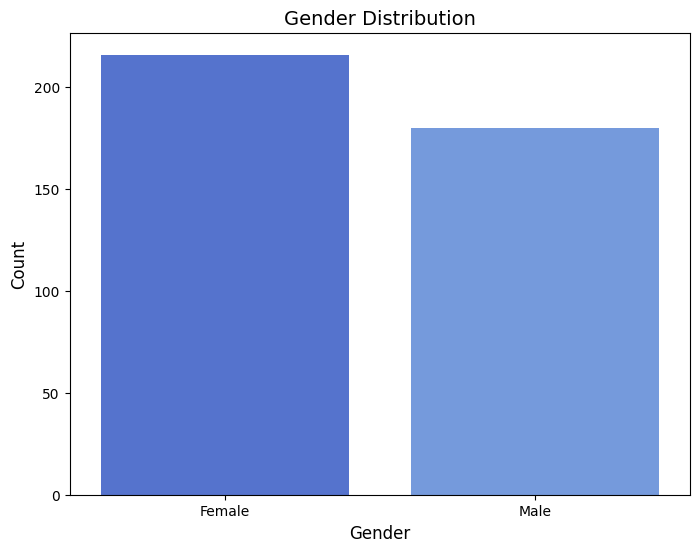

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_long is already loaded as shown in the provided code

# Sort the index for each plot
df_long_sorted = df_long.sort_index()


# Set a professional color palette
custom_palette = ["#4169E1", "#6495ED", "#B0C4DE", "#ADD8E6", "#87CEFA"]
df_long_sorted['Gender'] = df_long_sorted['Gender'].astype(str)
df_long_sorted = df_long_sorted[df_long_sorted['Gender']!=0]
df_long_sorted['Gender'] = df_long_sorted['Gender'].astype('category')

plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df_long_sorted, palette=custom_palette)
plt.title('Gender Distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

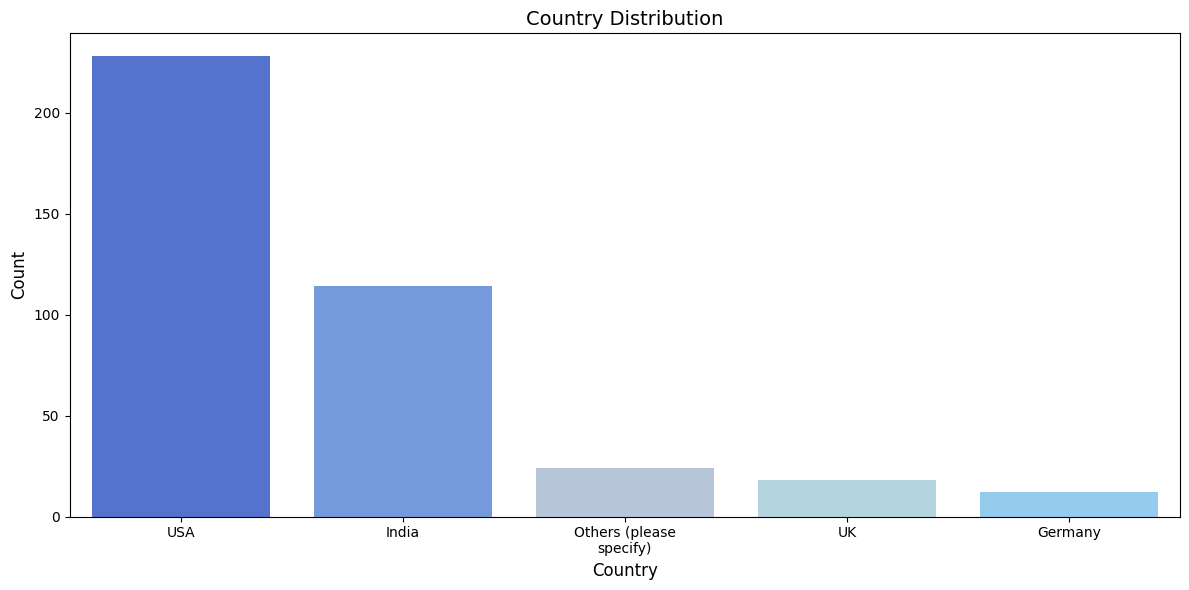

In [ ]:

df_long_sorted['Country'] = df_long_sorted['Country'].astype(str)
df_long_sorted = df_long_sorted[df_long_sorted['Country']!=0]
df_long_sorted['Country'] = df_long_sorted['Country'].astype('category')

# Plot for Country distribution
plt.figure(figsize=(12, 6))

# Sort bars and create countplot
ax = sns.countplot(x='Country', data=df_long_sorted, palette=custom_palette, order=df_long_sorted['Country'].value_counts().index)
plt.title('Country Distribution', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.yticks(fontsize=10)

# Rotate and wrap x-axis labels
ax.set_xticklabels(labels, ha='center', fontsize=10)

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

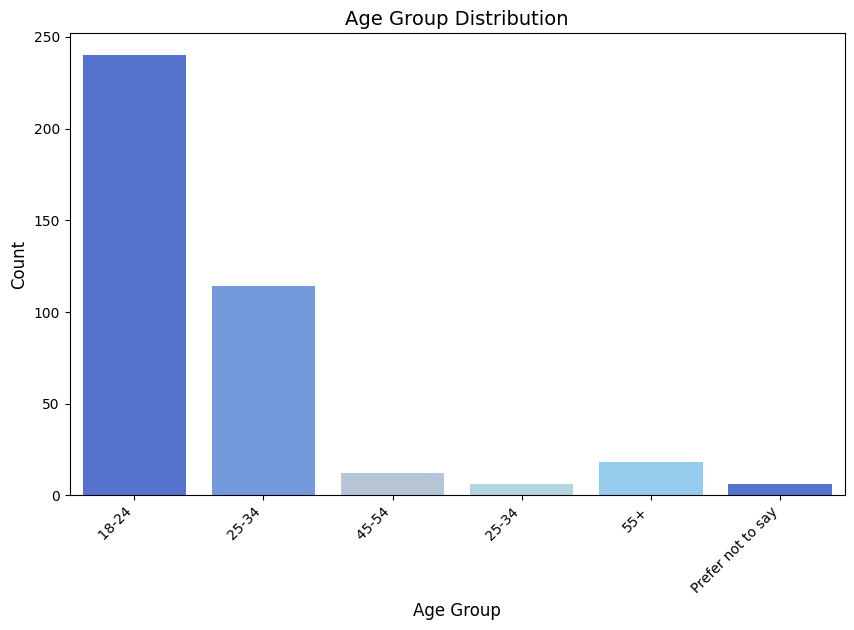

In [ ]:
df_long_sorted['Age_Group'] = df_long_sorted['Age_Group'].astype(str)
df_long_sorted = df_long_sorted[df_long_sorted['Age_Group']!=0]
df_long_sorted['Age_Group'] = df_long_sorted['Age_Group'].astype('category')# Plot for Age Group distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_Group', data=df_long_sorted, palette=custom_palette)
plt.title('Age Group Distribution', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right',fontsize=10)
plt.yticks(fontsize=10)
plt.show()


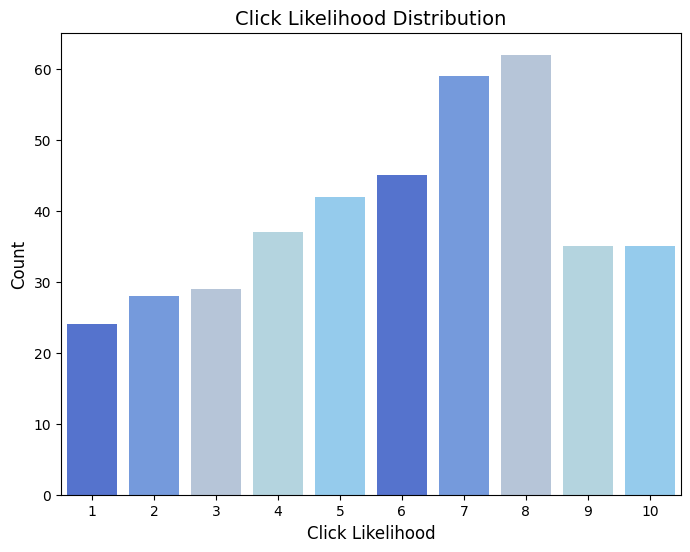

In [ ]:
df_long_sorted = df_long.sort_index()
ordered_values = sorted(df_long_sorted['Click_Likelihood'].dropna().astype(int).unique())

# Plot with sorted order
plt.figure(figsize=(8, 6))
sns.countplot(x='Click_Likelihood', data=df_long_sorted, order=ordered_values, palette=custom_palette)
plt.title('Click Likelihood Distribution', fontsize=14)
plt.xlabel('Click Likelihood', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

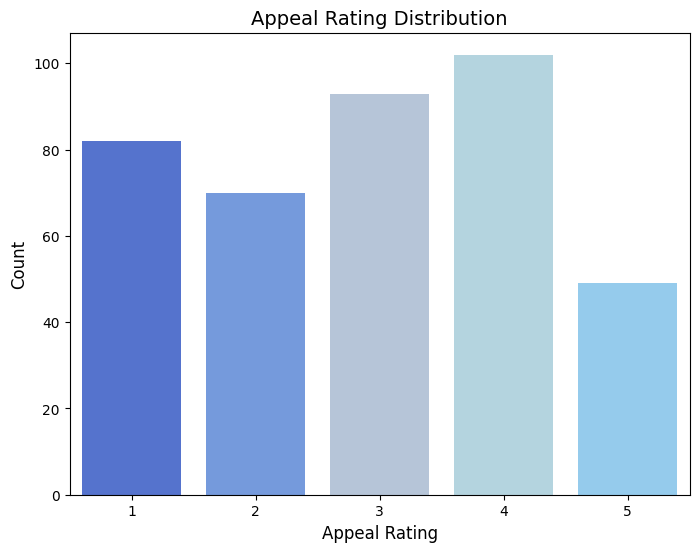

In [ ]:

#Plot for Appeal Rating Distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Appeal_Rating', data=df_long_sorted, palette = custom_palette)
plt.title('Appeal Rating Distribution', fontsize=14)
plt.xlabel('Appeal Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

## Randomization Test

In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.proportion as smp
from itertools import combinations

print("\nRandomization Check at Person-Brand Level:\n" + "-"*60)

for brand in df_long['Brand'].unique():
    print(f"\nRandomization Check for {brand}:\n" + "-"*50)

    df_brand = df_long[df_long['Brand'] == brand]  # Subset for each brand

    for demo in demographic_vars:
        # Count occurrences of each category within treatment groups
        counts = df_brand.groupby('Treatment')[demo].value_counts().unstack(fill_value=0)

        # Ensure at least two groups to compare
        if len(counts) < 2 or counts.shape[1] < 1:
            print(f"Skipping {demo} for {brand} due to insufficient data.")
            continue

        # Use Chi-square test for multi-category variables (Age_Group, Country)
        if demo in ['Age_Group', 'Country']:
            contingency_table = pd.crosstab(df_brand['Treatment'], df_brand[demo])
            chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
            print(f"{demo} (Chi-Square Test): Chi2 = {chi2:.3f}, p = {p_value:.3f}")

        # Use pairwise Z-test for binary variables (Gender)
        elif demo == 'Gender':
            treatment_groups = counts.index.tolist()
            p_values = []  # Collect p-values for multiple comparison correction

            for group1, group2 in combinations(treatment_groups, 2):
                count1 = counts.loc[group1].tolist()
                count2 = counts.loc[group2].tolist()

                total1 = sum(count1)
                total2 = sum(count2)

                # Skip if any category count is zero
                if count1[0] == 0 or count2[0] == 0:
                    print(f"Skipping {demo} ({group1} vs. {group2}) due to zero counts.")
                    continue

                # Conduct proportions Z-test
                z_stat, p_value = smp.proportions_ztest([count1[0], count2[0]], [total1, total2])
                p_values.append(p_value)

                print(f"{demo} ({group1} vs. {group2}): Z = {z_stat:.3f}, p = {p_value:.3f}")





Randomization Check at Person-Brand Level:
------------------------------------------------------------

Randomization Check for Apple:
--------------------------------------------------
Gender (Control vs. Treatment_1): Z = 1.131, p = 0.258
Gender (Control vs. Treatment_2): Z = 0.436, p = 0.663
Gender (Treatment_1 vs. Treatment_2): Z = -0.733, p = 0.464
Age_Group (Chi-Square Test): Chi2 = 8.126, p = 0.617
Country (Chi-Square Test): Chi2 = 11.533, p = 0.173

Randomization Check for Pepsi:
--------------------------------------------------
Gender (Control vs. Treatment_1): Z = -1.616, p = 0.106
Gender (Control vs. Treatment_2): Z = -0.733, p = 0.464
Gender (Treatment_1 vs. Treatment_2): Z = 0.949, p = 0.342
Age_Group (Chi-Square Test): Chi2 = 6.105, p = 0.806
Country (Chi-Square Test): Chi2 = 5.573, p = 0.695

Randomization Check for McD:
--------------------------------------------------
Gender (Control vs. Treatment_1): Z = 1.539, p = 0.124
Gender (Control vs. Treatment_2): Z = 0.816

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 2 to 67
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Duration (in seconds)  66 non-null     float64 
 1   ResponseId             66 non-null     object  
 2   Apple                  66 non-null     object  
 3   Q1                     66 non-null     category
 4   Q2                     66 non-null     category
 5   Q3                     66 non-null     Int64   
 6   Pepsi                  66 non-null     object  
 7   Q4                     66 non-null     category
 8   Q5                     66 non-null     category
 9   Q6                     66 non-null     Int64   
 10  McD                    66 non-null     object  
 11  Q7                     66 non-null     category
 12  Q8                     66 non-null     category
 13  Q9                     66 non-null     Int64   
 14  GreyGoose              66 non-null     objec

In [ ]:
df=df_long.copy()

## Cohen's D and Power Analysis




### Treatment Arms vs Control Group(Click_Likelihood,Appeal_Rating)

#### Cohen's D

In [ ]:
!pip install pingouin  # Updating Cohen's d calculation to include comparisons between both treatment arms (Vibrant vs. Vibrant + CTA)
import pingouin as pg

# Define outcome variables and treatment arms
outcomes = ["Click_Likelihood", "Appeal_Rating"]
treatment_arms = ["Treatment_1", "Treatment_2"]
purchase_status = ["Past_Buyers", "New_Users"]

# Dictionary to store results
cohens_d_results = {}

for outcome in outcomes:
    for treatment in treatment_arms:
        df[outcome] = pd.to_numeric(df[outcome], errors='coerce')
        cohens_d = pg.compute_effsize(
            df[df["Treatment"] == treatment][outcome],
            df[df["Treatment"] == "Control"][outcome],
            eftype="cohen"
        )
        if abs(cohens_d) < 0.2:
            effect_size_category = "Small"
        elif 0.2 <= abs(cohens_d) < 0.5:
            effect_size_category = "Medium"
        else:
            effect_size_category = "Large"
        cohens_d_results[f"{treatment} vs. Minimalist - {outcome}"] = (cohens_d, effect_size_category)

# Print results
print("Cohen's d Results:")
for key, value in cohens_d_results.items():
    print(f"{key}: {value}")

Cohen's d Results:
Treatment_1 vs. Minimalist - Click_Likelihood: (0.3482773421331501, 'Medium')
Treatment_2 vs. Minimalist - Click_Likelihood: (0.14027836185490933, 'Small')
Treatment_1 vs. Minimalist - Appeal_Rating: (0.02043276620715589, 'Small')
Treatment_2 vs. Minimalist - Appeal_Rating: (-0.18069633471918836, 'Small')


### Treatment Arm 1 vs Treatment Arm 2(Click_Likelihood,Appeal_Rating)


#### Cohen's D

In [ ]:
cohens_d_results={}
for outcome in outcomes:
    cohens_d = pg.compute_effsize(
        df[df["Treatment"] == "Treatment_2"][outcome],
        df[df["Treatment"] == "Treatment_1"][outcome],
        eftype="cohen"
    )
    if abs(cohens_d) < 0.2:
            effect_size_category = "Small"
    elif 0.2 <= abs(cohens_d) < 0.5:
            effect_size_category = "Medium"
    else:
            effect_size_category = "Large"

    cohens_d_results[f"Treatment_1 + Treatment_2 - {outcome}"] = (cohens_d,effect_size_category)

print("Cohen's d Results:")
for key, value in cohens_d_results.items():
    print(f"{key}: {value}")

Cohen's d Results:
Treatment_1 + Treatment_2 - Click_Likelihood: (-0.2172728179485719, 'Medium')
Treatment_1 + Treatment_2 - Appeal_Rating: (-0.19630036827898756, 'Small')


# T-tests

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ResponseId            396 non-null    object  
 1   Gender                396 non-null    category
 2   Age_Group             396 non-null    category
 3   Country               396 non-null    category
 4   Brand                 396 non-null    object  
 5   Treatment             396 non-null    object  
 6   Past_Buyers           396 non-null    int64   
 7   Click_Likelihood      396 non-null    int64   
 8   Appeal_Rating         396 non-null    int64   
 9   Frequency of Ads/Day  396 non-null    object  
dtypes: category(3), int64(3), object(4)
memory usage: 23.8+ KB


#### Click Likelihood as outcome

Effect of Treatment 1

In [ ]:
import scipy.stats as stats

# Making Q2 numeric
df['Click_Likelihood'] = pd.to_numeric(df['Click_Likelihood'], errors='coerce')

# Extract Q2 responses for the two groups
control_q2 = df.loc[df['Treatment'] == 'Control', 'Click_Likelihood']
treatment1_q2 = df.loc[df['Treatment'] == 'Treatment_1', 'Click_Likelihood']

# Conduct the independent t-test (using nan_policy='omit' to ignore missing values)
t_stat, p_val = stats.ttest_ind(control_q2, treatment1_q2, nan_policy='omit')

print("T-test (Control vs. Treatment_1) for Click_Likelihood:")
print("t-statistic = {:.3f}".format(t_stat))
print("p-value = {:.3f}".format(p_val))

T-test (Control vs. Treatment_1) for Click_Likelihood:
t-statistic = -2.921
p-value = 0.004


Effect of Treatment 2

In [ ]:
# Extract Q2 responses
treatment2_q2 = df.loc[df['Treatment'] == 'Treatment_2', 'Click_Likelihood']

# Conduct the independent t-test (using nan_policy='omit' to ignore missing values)
t_stat, p_val = stats.ttest_ind(control_q2, treatment2_q2, nan_policy='omit')

print("T-test (Control vs. Treatment_2) for Click_Likelihood:")
print("t-statistic = {:.3f}".format(t_stat))
print("p-value = {:.3f}".format(p_val))


T-test (Control vs. Treatment_2) for Click_Likelihood:
t-statistic = -1.126
p-value = 0.261


#### Appeal Rating as outcome

Treatment 1

In [ ]:
# Making Q3 numeric
df['Appeal_Rating'] = pd.to_numeric(df['Appeal_Rating'], errors='coerce')

# Extract Q2 responses for the two groups
control_q3 = df.loc[df['Treatment'] == 'Control', 'Appeal_Rating']
treatment1_q3 = df.loc[df['Treatment'] == 'Treatment_1', 'Appeal_Rating']

# Conduct the independent t-test (using nan_policy='omit' to ignore missing values)
t_stat, p_val = stats.ttest_ind(control_q3, treatment1_q3, nan_policy='omit')

print("T-test (Control vs. Treatment_1) for Appeal_Rating:")
print("t-statistic = {:.3f}".format(t_stat))
print("p-value = {:.3f}".format(p_val))


T-test (Control vs. Treatment_1) for Appeal_Rating:
t-statistic = -0.171
p-value = 0.864


Treatment 2

In [ ]:
# Extract Q2 responses
treatment2_q3 = df.loc[df['Treatment'] == 'Treatment_2', 'Appeal_Rating']

# Conduct the independent t-test (using nan_policy='omit' to ignore missing values)
t_stat, p_val = stats.ttest_ind(control_q3, treatment2_q3, nan_policy='omit')

print("T-test (Control vs. Treatment_2) for Appeal_Rating:")
print("t-statistic = {:.3f}".format(t_stat))
print("p-value = {:.3f}".format(p_val))


T-test (Control vs. Treatment_2) for Appeal_Rating:
t-statistic = 1.450
p-value = 0.148


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ResponseId            396 non-null    object  
 1   Gender                396 non-null    category
 2   Age_Group             396 non-null    category
 3   Country               396 non-null    category
 4   Brand                 396 non-null    object  
 5   Treatment             396 non-null    object  
 6   Past_Buyers           396 non-null    int64   
 7   Click_Likelihood      396 non-null    int64   
 8   Appeal_Rating         396 non-null    int64   
 9   Frequency of Ads/Day  396 non-null    object  
dtypes: category(3), int64(3), object(4)
memory usage: 23.8+ KB


#ATE AND CATE

In [ ]:
import pandas as pd

# Define the outcomes and treatment groups
outcomes = ["Appeal_Rating", "Click_Likelihood"]
treatments = ["Treatment_1", "Treatment_2"]

# Create a nested dictionary to store ATEs
ate_dict = {}

# Loop over treatments and outcomes
for treatment in treatments:
    ate_dict[treatment] = {}
    for outcome in outcomes:
        # Calculate the mean outcome for the control group and the treatment group
        control_mean = df.loc[df["Treatment"] == "Control", outcome].mean()
        treatment_mean = df.loc[df["Treatment"] == treatment, outcome].mean()
        # ATE is the difference in means
        ate = treatment_mean - control_mean
        ate_dict[treatment][outcome] = ate

# Create a DataFrame (2x2 matrix) from the nested dictionary
ate_matrix = pd.DataFrame(ate_dict).T  # Transpose so treatments are rows and outcomes are columns

# Optionally, rename the index and columns for clarity
ate_matrix.index.name = "Treatment"
ate_matrix.columns = outcomes

print("Average Treatment Effects (ATE):")
print(ate_matrix)


Average Treatment Effects (ATE):
             Appeal_Rating  Click_Likelihood
Treatment                                   
Treatment_1       0.027027          0.910044
Treatment_2      -0.236131          0.371029


In [ ]:
def compute_cate_by_covariate(df, conditioning_var, outcomes, treatments):
    """
    For a given conditioning variable (e.g., Gender), compute the Conditional ATE (CATE)
    for each treatment-outcome pair within each subgroup.

    Returns:
        A dictionary where each key is a subgroup (level of conditioning_var) and the
        value is a DataFrame (2x2 matrix) with rows as treatments and columns as outcomes.
    """
    cate_results = {}
    # Loop over each subgroup in the conditioning variable (sorted for consistent order)
    for group in sorted(df[conditioning_var].unique()):
        group_df = df[df[conditioning_var] == group]
        # Create an empty DataFrame to store CATEs for this subgroup
        cate_matrix = pd.DataFrame(index=treatments, columns=outcomes)
        # Compute control means for each outcome within this subgroup
        control_means = {}
        for outcome in outcomes:
            control_means[outcome] = group_df.loc[group_df["Treatment"] == "Control", outcome].mean()
        # For each treatment and outcome, compute the difference (treatment minus control)
        for treatment in treatments:
            for outcome in outcomes:
                treatment_mean = group_df.loc[group_df["Treatment"] == treatment, outcome].mean()
                cate_matrix.loc[treatment, outcome] = treatment_mean - control_means[outcome]
        cate_results[group] = cate_matrix
    return cate_results

# Define parameters
outcomes = ["Appeal_Rating", "Click_Likelihood"]
treatments = ["Treatment_1", "Treatment_2"]
conditioning_var = "Gender"  # You can change this to any valid covariate, e.g., "Age_Group" or "Country"

# Calculate the CATE matrices for the chosen conditioning variable
cate_matrices = compute_cate_by_covariate(df, conditioning_var, outcomes, treatments)

# Display the results as neat 2x2 matrices for each subgroup
for group, matrix in cate_matrices.items():
    print(f"\nCATE matrix for {conditioning_var} = {group}:")
    print(matrix)



CATE matrix for Gender = Female:
            Appeal_Rating Click_Likelihood
Treatment_1     -0.059867         1.209059
Treatment_2     -0.334189         0.675225

CATE matrix for Gender = Male:
            Appeal_Rating Click_Likelihood
Treatment_1      0.154705          0.54386
Treatment_2     -0.161085        -0.017544


In [ ]:
df_clean.head()

,ResponseId,Gender,Age_Group,Country,Brand,Treatment,Past_Buyers,Click_Likelihood,Appeal_Rating,FreqAds
0,R_3XeOwXVvVvhXGQV,Female,25-34,USA,Apple,Treatment_2,0,6,3,5-10
22,R_4PwauT1wBKerHyx,Female,55+,India,Apple,Control,0,2,1,1-5
23,R_4u13E5aO02L5hnP,Male,55+,India,Apple,Control,0,5,3,1-5
31,R_9fcmTaJ5bwbvFp9,Female,55+,India,Apple,Treatment_2,0,1,1,1-5
39,R_9r8nnGyY4av8sff,Female,Prefer not to say,India,Apple,Treatment_2,1,6,1,5-10


In [ ]:
# Calculate the CATE matrices for the chosen conditioning variable
cate_matrices = compute_cate_by_covariate(df, "Country", outcomes, treatments)

# Display the results as neat 2x2 matrices for each subgroup
for group, matrix in cate_matrices.items():
    print(f"\nCATE matrix for {conditioning_var} = {group}:")
    print(matrix)


CATE matrix for Gender = Germany:
            Appeal_Rating Click_Likelihood
Treatment_1     -0.166667              2.0
Treatment_2      0.133333              0.0

CATE matrix for Gender = India:
            Appeal_Rating Click_Likelihood
Treatment_1     -0.458065         0.533871
Treatment_2     -0.734884         0.073256

CATE matrix for Gender = Others (please specify):
            Appeal_Rating Click_Likelihood
Treatment_1       0.30303         1.530303
Treatment_2     -1.077922        -1.350649

CATE matrix for Gender = UK:
            Appeal_Rating Click_Likelihood
Treatment_1      0.857143         3.571429
Treatment_2      0.428571         3.035714

CATE matrix for Gender = USA:
            Appeal_Rating Click_Likelihood
Treatment_1      0.172815         0.842155
Treatment_2      0.119749         0.556531


In [ ]:
# Calculate the CATE matrices for the chosen conditioning variable
cate_matrices = compute_cate_by_covariate(df, "Age_Group", outcomes, treatments)

# Display the results as neat 2x2 matrices for each subgroup
for group, matrix in cate_matrices.items():
    print(f"\nCATE matrix for {conditioning_var} = {group}:")
    print(matrix)


CATE matrix for Gender =  18-24:
            Appeal_Rating Click_Likelihood
Treatment_1     -0.065789         1.056919
Treatment_2         -0.12         0.559551

CATE matrix for Gender =  25-34:
            Appeal_Rating Click_Likelihood
Treatment_1      0.570938         1.226545
Treatment_2     -0.108772         0.352632

CATE matrix for Gender =  45-54:
            Appeal_Rating Click_Likelihood
Treatment_1     -0.392857             0.75
Treatment_2      0.857143              0.0

CATE matrix for Gender = 25-34:
            Appeal_Rating Click_Likelihood
Treatment_1     -1.666667        -4.333333
Treatment_2          -1.0             -2.0

CATE matrix for Gender = 55+:
            Appeal_Rating Click_Likelihood
Treatment_1     -1.727273        -2.727273
Treatment_2     -2.477273        -4.727273

CATE matrix for Gender = Prefer not to say:
            Appeal_Rating Click_Likelihood
Treatment_1           0.0              3.0
Treatment_2           0.0              3.0


In [ ]:
# Calculate the CATE matrices for the chosen conditioning variable
cate_matrices = compute_cate_by_covariate(df, "Brand", outcomes, treatments)

# Display the results as neat 2x2 matrices for each subgroup
for group, matrix in cate_matrices.items():
    print(f"\nCATE matrix for {conditioning_var} = {group}:")
    print(matrix)


CATE matrix for Gender = Apple:
            Appeal_Rating Click_Likelihood
Treatment_1     -0.100877         1.096491
Treatment_2     -0.771167          0.21968

CATE matrix for Gender = Emirates:
            Appeal_Rating Click_Likelihood
Treatment_1      0.103077         1.569231
Treatment_2      0.346667              1.4

CATE matrix for Gender = GreyGoose:
            Appeal_Rating Click_Likelihood
Treatment_1      -0.13834         0.885375
Treatment_2      0.484848         0.411255

CATE matrix for Gender = McD:
            Appeal_Rating Click_Likelihood
Treatment_1      0.685619          1.38796
Treatment_2      0.135747         1.692308

CATE matrix for Gender = Nike:
            Appeal_Rating Click_Likelihood
Treatment_1      -0.23126        -0.314195
Treatment_2     -0.614719         -0.71645

CATE matrix for Gender = Pepsi:
            Appeal_Rating Click_Likelihood
Treatment_1      0.320366         1.421053
Treatment_2      0.019928         0.791667


# Regressions

In [ ]:
!pip install stargazer

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Define valid responses for our categorical variables
valid_age = ["18-24", "25-34", "45-54", "55+", "Prefer not to say"]
valid_gender = ["Male", "Female", "Prefer not to say"]
valid_country = ["USA", "UK", "India", "Others (please specify)"]

# Filter the dataframe for only valid responses
df_clean = df[
    df["Age_Group"].isin(valid_age) &
    df["Gender"].isin(valid_gender) &
    df["Country"].isin(valid_country)
].copy()

# Remove unused category levels from the categorical columns
for col in ['Age_Group', 'Gender', 'Country']:
    if hasattr(df_clean[col], 'cat'):
        df_clean[col] = df_clean[col].cat.remove_unused_categories()

# Rename "Frequency of Ads/Day" to "FreqAds" for convenience
df_clean = df_clean.rename(columns={"Frequency of Ads/Day": "FreqAds"})
if not pd.api.types.is_categorical_dtype(df_clean["FreqAds"]):
    df_clean["FreqAds"] = df_clean["FreqAds"].astype("category")
df_clean["FreqAds"] = df_clean["FreqAds"].cat.remove_unused_categories()

# Ensure the outcome variable is numeric
df_clean['Click_Likelihood'] = pd.to_numeric(df_clean['Click_Likelihood'], errors='coerce')

# Regression 1: Only treatment as predictor
model1 = smf.ols("Click_Likelihood ~ C(Treatment)", data=df_clean).fit()

# Regression 2: Treatment plus additional covariates
model2 = smf.ols("Click_Likelihood ~ C(Treatment) + C(Gender) + C(Age_Group) + C(Country) + C(FreqAds)", data=df_clean).fit()

# Generate a combined stargazer table for both models
stargazer_table = Stargazer([model1])

html_output = stargazer_table.render_html()

# Displaying the HTML table
display(HTML(html_output))

In [ ]:
stargazer_table = Stargazer([model2])

html_output = stargazer_table.render_html()

# Displaying the HTML table
display(HTML(html_output))

#### Interpretation

Here's a concise interpretation:

**Model (1):**  
- **Demographics & Ad Exposure:**  
  - Being 55+ or “Prefer not to say” about age increases click likelihood by about 0.97 and 1.94 points, respectively.  
  - Viewing ads 5–10 times a day boosts click likelihood by 2.64 points, and males are predicted to click 4.30 points more than the reference group.  
- **Treatment Effects:**  
  - Compared to the control, Treatment_1 shows a 2.09-point reduction (not statistically significant) and Treatment_2 a 2.34-point reduction (marginally significant).  
- **Overall Fit:**  
  - The model explains 14% of the variation in click likelihood (R² = 0.14).

**Model (2) (with additional covariates):**  
- **Improved Fit:**  
  - The model explains nearly 50% of the variation (R² = 0.496), indicating that including demographics and ad frequency substantially improves prediction.  
- **Adjusted Treatment Effects:**  
  - After controlling for covariates, Treatment_1 is associated with a significant 2.29-point decrease in click likelihood, while Treatment_2’s 1.86-point reduction is not statistically significant.  

Overall, the results suggest that higher ad frequency and being male strongly increase click likelihood, and when accounting for these factors, the treatment conditions (particularly Treatment_1) reduce the probability of clicking compared to the control.

### Appeal Rating as outcome

In [ ]:
# Define valid responses for our categorical variables
valid_age = ["18-24", "25-34", "45-54", "55+", "Prefer not to say"]
valid_gender = ["Male", "Female", "Prefer not to say"]
valid_country = ["USA", "UK", "India", "Others (please specify)"]

# Filter the dataframe for only valid responses
df_clean = df[
    df["Age_Group"].isin(valid_age) &
    df["Gender"].isin(valid_gender) &
    df["Country"].isin(valid_country)
].copy()

# Remove unused category levels from categorical columns
for col in ['Age_Group', 'Gender', 'Country']:
    if hasattr(df_clean[col], 'cat'):
        df_clean[col] = df_clean[col].cat.remove_unused_categories()

# Rename "Frequency of Ads/Day" to "FreqAds" for convenience.
# (If FreqAds is not already a category and you wish to treat it as one, you can convert it.)
df_clean = df_clean.rename(columns={"Frequency of Ads/Day": "FreqAds"})
if not pd.api.types.is_categorical_dtype(df_clean["FreqAds"]):
    df_clean["FreqAds"] = df_clean["FreqAds"].astype("category")
df_clean["FreqAds"] = df_clean["FreqAds"].cat.remove_unused_categories()

# Ensure the outcome variable is numeric
df_clean['Appeal_Rating'] = pd.to_numeric(df_clean['Appeal_Rating'], errors='coerce')

# Run Regression 1: Only treatment as predictor
model1 = smf.ols("Appeal_Rating ~ C(Treatment)", data=df_clean).fit()

# Run Regression 2: Treatment plus additional covariates
model2 = smf.ols("Appeal_Rating ~ C(Treatment) + C(Gender) + C(Age_Group) + C(Country) + C(FreqAds)", data=df_clean).fit()

# Generate a combined stargazer table for both models
stargazer_table1 = Stargazer([model1])

html_output1 = stargazer_table1.render_html()

# Displaying the HTML table
display(HTML(html_output1))


In [ ]:

# Generate a combined stargazer table for both models
stargazer_table1 = Stargazer([model2])

html_output1 = stargazer_table1.render_html()

# Displaying the HTML table
display(HTML(html_output1))

#### Interpretation

**Interpretation of Model 1:**

- **Baseline:**  
  The intercept (3.571) represents the predicted Appeal_Rating for the baseline respondent.

- **Treatment Effects:**  
  - **Treatment_1:** Associated with a 1.70-point decrease in Appeal_Rating relative to the control group.  
  - **Treatment_2:** Associated with an even larger decrease of about 2.20 points compared to control.

- **Model Fit:**  
  The model explains about 43% of the variance in Appeal_Rating (R² = 0.434) with a significant overall F-statistic.

Overall, Model 1 indicates that both treatment conditions significantly reduce the appeal compared to the control condition.

---


**Model (2) Findings:**
- **Demographics & Ad Exposure:**  
  - Participants aged 55+ rate the ad about 1.09 points higher.
  - U.S. respondents score 1.28 points higher.
  - Males rate appeal 1.44 points higher.
  - Viewing ads 5–10 times a day is associated with a 0.80-point increase in appeal.
- **Treatment Effects:**  
  - Compared to the control, Treatment_1 reduces appeal by about 1.46 points.
  - Treatment_2 lowers appeal by roughly 1.43 points.
- **Overall Model Fit:**  
  - Including these covariates improves the model, explaining about 67% of the variance in appeal ratings.

This suggests that while demographics and ad exposure frequency positively affect appeal, both treatment ad variations consistently reduce it relative to the control.